### Library Imports

In [1]:
import os
import re
import gc
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from time import time, sleep
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
from torchvision import models, transforms

from sklearn.model_selection import KFold
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import accuracy_score, \
#                             precision_recall_fscore_support, \
#                             roc_auc_score, \
#                             classification_report, \
#                             confusion_matrix

### **Utilities**

In [2]:
SEED = 42
SIZE = 384

def breaker(num: int=50, char: str="*") -> None:
    print("\n" + num*char + "\n")


def show_graphs(L: list, A: list) -> None:
    TL, VL, TA, VA = [], [], [], []
    for i in range(len(L)):
        TL.append(L[i]["train"])
        VL.append(L[i]["valid"])
        TA.append(A[i]["train"])
        VA.append(A[i]["valid"])
    x_Axis = np.arange(1, len(TL) + 1)
    plt.figure(figsize=(8, 6))
    plt.subplot(1, 2, 1)
    plt.plot(x_Axis, TL, "r", label="Train")
    plt.plot(x_Axis, VL, "b", label="Valid")
    plt.legend()
    plt.grid()
    plt.title("Loss Graph")
    plt.subplot(1, 2, 2)
    plt.plot(x_Axis, TA, "r", label="Train")
    plt.plot(x_Axis, VA, "b", label="Valid")
    plt.legend()
    plt.grid()
    plt.title("Accuracy Graph")
    plt.show()

    
def get_scores(y_true: np.ndarray, y_pred: np.ndarray) -> tuple:
    accuracy = accuracy_score(y_pred, y_true)
    try:
        auc = roc_auc_score(y_pred, y_true)
    except:
        auc = 0
    precision, recall, f_score, _ = precision_recall_fscore_support(y_pred, y_true)

    return accuracy, auc, precision, recall, f_score


def print_scores(accuracy: float, auc: float, precision: np.ndarray, recall: np.ndarray, f_score: np.ndarray) -> None:
    print(f"Accuracy  : {accuracy:.5f}")
    print(f"ROC-AUC   : {auc:.5f}")
    print(f"Precision : {precision}")
    print(f"Recall    : {recall}")
    print(f"F-Score   : {f_score}")

### **Configuration**

In [3]:
class CFG(object):
    def __init__(self, 
                 seed: int = 42,
                 n_splits: int = 5,
                 batch_size: int = 16,
                 epochs: int = 25,
                 early_stopping: int = 5,
                 lr: float = 1e-4,
                 wd: float = 0.0,
                 max_lr: float = 1e-3,
                 pct_start: float = 0.2,
                 steps_per_epoch: int = 100,
                 div_factor: int = 1e3, 
                 final_div_factor: float = 1e3,
                 ):
        
        self.seed = seed
        self.n_splits = n_splits
        self.batch_size = batch_size
        self.epochs = epochs
        self.early_stopping = early_stopping
        self.lr = lr
        self.wd = wd
        self.max_lr = max_lr
        self.pct_start = pct_start
        self.steps_per_epoch = steps_per_epoch
        self.div_factor = div_factor
        self.final_div_factor = final_div_factor
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.50122, 0.50962, 0.51243],
                                                     [0.25932, 0.25939, 0.26068]),
                                ])
        self.save_path = "saves"
        if not os.path.exists(self.save_path): os.makedirs(self.save_path)
    
cfg = CFG(seed=SEED)

### **Dataset Template**

In [4]:
class DS(Dataset):
    def __init__(self, images: np.ndarray, labels: np.ndarray = None, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, idx):
        if self.labels is not None:
            return self.transform(self.images[idx]), torch.FloatTensor(self.labels[idx])
        else:
            return self.transform(self.images[idx])

### **Model**

In [5]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.model = models.densenet169(pretrained=True, progress=True)
        self.model.classifier = nn.Linear(in_features=self.model.classifier.in_features, out_features=1)

    def forward(self, x):
        return self.model(x)

### Fit and Predict Helper

In [6]:
def fit(model=None, 
        optimizer=None,
        scheduler_rlrop=None,
        scheduler_oclr=None, 
        epochs=None, 
        early_stopping_patience=None, 
        dataloaders=None, 
        fold=None, 
        save_path=None, 
        device=None,
        verbose=False) -> tuple:
    
    def get_accuracy(y_pred, y_true):
        y_pred = torch.sigmoid(y_pred)
        
        y_pred[y_pred > 0.5] = 1
        y_pred[y_pred <= 0.5] = 0
        
        return torch.count_nonzero(y_pred == y_true).item() / len(y_pred)
    
    if verbose:
        breaker()
        if fold: print(f"Training Fold {fold}...")
        else: print("Training ...")
        breaker()
        
    bestLoss, bestAccs = {"train" : np.inf, "valid" : np.inf}, {"train" : 0.0, "valid" : 0.0}
    Losses, LRs, Accuracies = [], [], []
    if fold: name = f"state_fold_{fold}.pt"
    else: name = "state.pt"

    start_time = time()
    for e in range(epochs):
        e_st = time()
        epochLoss, epochAccs = {"train" : 0.0, "valid" : 0.0}, {"train" : 0.0, "valid" : 0.0}

        for phase in ["train", "valid"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            
            lossPerPass, accsPerPass = [], []

            for X, y in dataloaders[phase]:
                X, y = X.to(device), y.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    output = model(X)
                    loss = torch.nn.BCEWithLogitsLoss()(output, y)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                        if scheduler_oclr: scheduler_oclr.step()
                lossPerPass.append(loss.item())
                accsPerPass.append(get_accuracy(output, y))
            epochLoss[phase] = np.mean(np.array(lossPerPass))
            epochAccs[phase] = np.mean(np.array(accsPerPass))
        if scheduler_oclr: LRs.append(scheduler_oclr.get_last_lr())
        Losses.append(epochLoss)
        Accuracies.append(epochAccs)
        
        if scheduler_oclr:
            save_dict = {"model_state_dict"     : model.state_dict(),
                         "optim_state_dict"     : optimizer.state_dict(),
                         "scheduler_state_dict" : scheduler_oclr.state_dict()}
        
        elif scheduler_rlrop:
            save_dict = {"model_state_dict"     : model.state_dict(),
                         "optim_state_dict"     : optimizer.state_dict(),
                         "scheduler_state_dict" : scheduler_rlrop.state_dict()}
        
        else:
            save_dict = {"model_state_dict"     : model.state_dict(),
                         "optim_state_dict"     : optimizer.state_dict()}
        
        if early_stopping_patience:
            if epochLoss["valid"] < bestLoss["valid"]:
                bestLoss = epochLoss
                BLE = e + 1
                torch.save(save_dict, os.path.join(save_path, name))
                early_stopping_step = 0
            else:
                early_stopping_step += 1
                if early_stopping_step > early_stopping_patience:
                    print("\nEarly Stopping at Epoch {}".format(e + 1))
                    break
        
        if epochLoss["valid"] < bestLoss["valid"]:
            bestLoss = epochLoss
            BLE = e + 1
            torch.save(save_dict, os.path.join(save_path, name))
        
        if epochAccs["valid"] > bestAccs["valid"]:
            bestAccs = epochAccs
            BAE = e + 1            
            # torch.save(save_dict, os.path.join(save_path, name))

        
        if scheduler_rlrop: scheduler_rlrop.step(epochLoss["valid"])
        
        if verbose:
            print("Epoch: {} | Train Loss: {:.5f} | Valid Loss: {:.5f} | Train Accs: {:.5f} | Valid Accs: {:.5f} | Time: {:.2f} seconds".format(e+1, 
                                                                       epochLoss["train"], epochLoss["valid"], 
                                                                       epochAccs["train"], epochAccs["valid"], 
                                                                       time()-e_st))

    del model, X, y
    torch.cuda.empty_cache()
    
    if verbose:                                           
        breaker()
        print(f"Best Validation Loss at Epoch {BLE}")
        breaker()
        print(f"Best Validation Accs at Epoch {BAE}")
        breaker()
        print("Time Taken [{} Epochs] : {:.2f} minutes".format(len(Losses), (time()-start_time)/60))
    
    return Losses, Accuracies, LRs, BLE, BAE, name


def predict(model=None, dataloader=None, path=None, device=None) -> np.ndarray:
    model.load_state_dict(torch.load(path, map_location=device)["model_state_dict"])
    model.to(device)    
    model.eval()
    
    y_pred = torch.zeros(1, 1).to(device)
    
    for X in dataloader:
        X = X.to(device)
        with torch.no_grad():
            output = torch.sigmoid(model(X))
        y_pred = torch.cat((y_pred, output.view(-1, 1)), dim=0)
    
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0
    
    return y_pred[1:].detach().cpu().numpy()

### **Train**

In [7]:
images = np.load(f"../input/tbcxr-images/images_{SIZE}.npy")
labels = np.load(f"../input/tbcxr-images/targets_{SIZE}.npy")

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth


  0%|          | 0.00/54.7M [00:00<?, ?B/s]


**************************************************

Training Fold 1...

**************************************************

Epoch: 1 | Train Loss: 0.29521 | Valid Loss: 0.03640 | Train Accs: 0.85774 | Valid Accs: 0.99292 | Time: 92.40 seconds
Epoch: 2 | Train Loss: 0.04676 | Valid Loss: 0.01382 | Train Accs: 0.98720 | Valid Accs: 0.99646 | Time: 85.90 seconds
Epoch: 3 | Train Loss: 0.03950 | Valid Loss: 0.25514 | Train Accs: 0.98839 | Valid Accs: 0.91509 | Time: 85.19 seconds
Epoch: 4 | Train Loss: 0.05176 | Valid Loss: 0.07219 | Train Accs: 0.98363 | Valid Accs: 0.99057 | Time: 85.40 seconds
Epoch: 5 | Train Loss: 0.03583 | Valid Loss: 0.11406 | Train Accs: 0.98690 | Valid Accs: 0.96108 | Time: 84.31 seconds
Epoch: 6 | Train Loss: 0.02945 | Valid Loss: 0.03960 | Train Accs: 0.99107 | Valid Accs: 0.98939 | Time: 85.14 seconds
Epoch: 7 | Train Loss: 0.02379 | Valid Loss: 0.00920 | Train Accs: 0.99256 | Valid Accs: 0.99882 | Time: 86.01 seconds
Epoch: 8 | Train Loss: 0.01262 | Valid Los

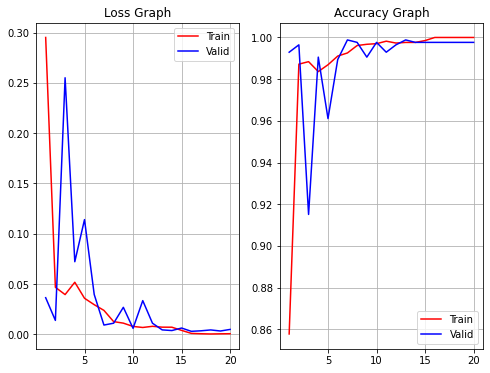


**************************************************

Training Fold 2...

**************************************************

Epoch: 1 | Train Loss: 0.29947 | Valid Loss: 0.01660 | Train Accs: 0.84673 | Valid Accs: 0.99882 | Time: 85.00 seconds
Epoch: 2 | Train Loss: 0.03619 | Valid Loss: 0.00625 | Train Accs: 0.99167 | Valid Accs: 1.00000 | Time: 85.02 seconds
Epoch: 3 | Train Loss: 0.06825 | Valid Loss: 0.28183 | Train Accs: 0.97857 | Valid Accs: 0.93632 | Time: 84.35 seconds
Epoch: 4 | Train Loss: 0.05633 | Valid Loss: 0.33147 | Train Accs: 0.98304 | Valid Accs: 0.84198 | Time: 84.35 seconds
Epoch: 5 | Train Loss: 0.02831 | Valid Loss: 0.00770 | Train Accs: 0.99137 | Valid Accs: 0.99764 | Time: 84.30 seconds
Epoch: 6 | Train Loss: 0.05327 | Valid Loss: 0.01677 | Train Accs: 0.98333 | Valid Accs: 0.99528 | Time: 84.71 seconds
Epoch: 7 | Train Loss: 0.03166 | Valid Loss: 0.06200 | Train Accs: 0.99018 | Valid Accs: 0.97642 | Time: 84.58 seconds

Early Stopping at Epoch 8

**************

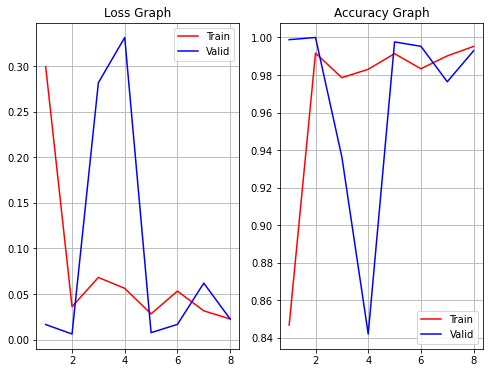


**************************************************

Training Fold 3...

**************************************************

Epoch: 1 | Train Loss: 0.29760 | Valid Loss: 0.03544 | Train Accs: 0.85119 | Valid Accs: 0.99292 | Time: 85.08 seconds
Epoch: 2 | Train Loss: 0.04228 | Valid Loss: 0.18689 | Train Accs: 0.99018 | Valid Accs: 0.93160 | Time: 84.32 seconds
Epoch: 3 | Train Loss: 0.04138 | Valid Loss: 0.75945 | Train Accs: 0.98929 | Valid Accs: 0.90802 | Time: 84.21 seconds
Epoch: 4 | Train Loss: 0.06653 | Valid Loss: 0.04869 | Train Accs: 0.97887 | Valid Accs: 0.99175 | Time: 84.35 seconds
Epoch: 5 | Train Loss: 0.02827 | Valid Loss: 0.03282 | Train Accs: 0.99107 | Valid Accs: 0.99175 | Time: 85.00 seconds
Epoch: 6 | Train Loss: 0.03383 | Valid Loss: 0.14793 | Train Accs: 0.99018 | Valid Accs: 0.93160 | Time: 84.55 seconds
Epoch: 7 | Train Loss: 0.03590 | Valid Loss: 0.08603 | Train Accs: 0.98780 | Valid Accs: 0.98703 | Time: 84.39 seconds
Epoch: 8 | Train Loss: 0.01869 | Valid Los

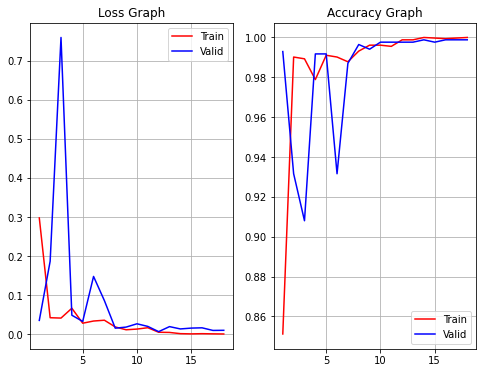


**************************************************

Training Fold 4...

**************************************************

Epoch: 1 | Train Loss: 0.29450 | Valid Loss: 0.03331 | Train Accs: 0.85446 | Valid Accs: 0.99292 | Time: 84.52 seconds
Epoch: 2 | Train Loss: 0.04057 | Valid Loss: 0.02186 | Train Accs: 0.98869 | Valid Accs: 0.99764 | Time: 84.81 seconds
Epoch: 3 | Train Loss: 0.04000 | Valid Loss: 0.24973 | Train Accs: 0.98899 | Valid Accs: 0.89741 | Time: 84.38 seconds
Epoch: 4 | Train Loss: 0.09119 | Valid Loss: 0.08163 | Train Accs: 0.97440 | Valid Accs: 0.96226 | Time: 84.32 seconds
Epoch: 5 | Train Loss: 0.04017 | Valid Loss: 0.20882 | Train Accs: 0.98899 | Valid Accs: 0.90566 | Time: 84.27 seconds
Epoch: 6 | Train Loss: 0.02999 | Valid Loss: 0.00825 | Train Accs: 0.99256 | Valid Accs: 0.99882 | Time: 84.80 seconds
Epoch: 7 | Train Loss: 0.02207 | Valid Loss: 0.18862 | Train Accs: 0.99286 | Valid Accs: 0.96698 | Time: 84.30 seconds
Epoch: 8 | Train Loss: 0.02006 | Valid Los

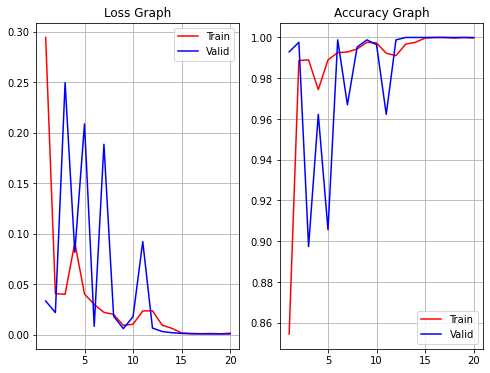


**************************************************

Training Fold 5...

**************************************************

Epoch: 1 | Train Loss: 0.29863 | Valid Loss: 0.02987 | Train Accs: 0.85000 | Valid Accs: 0.99528 | Time: 84.69 seconds
Epoch: 2 | Train Loss: 0.04520 | Valid Loss: 0.05989 | Train Accs: 0.98899 | Valid Accs: 0.98113 | Time: 84.38 seconds
Epoch: 3 | Train Loss: 0.07053 | Valid Loss: 0.30265 | Train Accs: 0.97768 | Valid Accs: 0.88325 | Time: 84.67 seconds
Epoch: 4 | Train Loss: 0.08761 | Valid Loss: 0.08511 | Train Accs: 0.97679 | Valid Accs: 0.96934 | Time: 84.43 seconds
Epoch: 5 | Train Loss: 0.04105 | Valid Loss: 0.01938 | Train Accs: 0.98601 | Valid Accs: 0.99528 | Time: 84.82 seconds
Epoch: 6 | Train Loss: 0.04318 | Valid Loss: 0.04625 | Train Accs: 0.98601 | Valid Accs: 0.98231 | Time: 84.29 seconds
Epoch: 7 | Train Loss: 0.02873 | Valid Loss: 0.03979 | Train Accs: 0.99048 | Valid Accs: 0.98231 | Time: 84.24 seconds
Epoch: 8 | Train Loss: 0.01732 | Valid Los

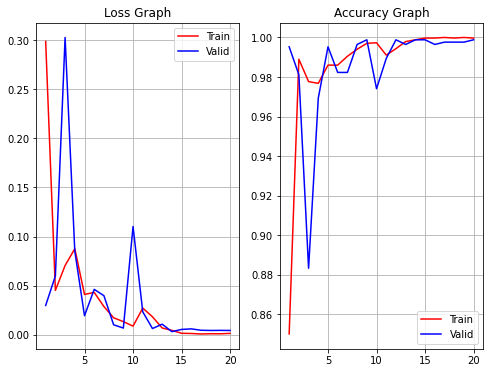

In [8]:
fold = 1
BLEs, BAEs = [], []

for tr_idx, va_idx in KFold(n_splits=cfg.n_splits, random_state=cfg.seed, shuffle=True).split(images):
    tr_images, va_images, tr_labels, va_labels = images[tr_idx], images[va_idx], labels[tr_idx], labels[va_idx]

    tr_data_setup = DS(tr_images, tr_labels.reshape(-1, 1), cfg.transform)
    va_data_setup = DS(va_images, va_labels.reshape(-1, 1), cfg.transform)

    dataloaders = {
        "train" : DL(tr_data_setup, batch_size=cfg.batch_size, shuffle=True, generator=torch.manual_seed(cfg.seed)),
        "valid" : DL(va_data_setup, batch_size=cfg.batch_size, shuffle=False),
    }

    cfg = CFG(epochs=20, lr=1e-3, wd=0.0, batch_size=16, steps_per_epoch=len(dataloaders["train"]))

    torch.manual_seed(cfg.seed)
    model = Model().to(cfg.device)
    
    optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=cfg.lr, weight_decay=cfg.wd)
    # optimizer = optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=cfg.lr, weight_decay=cfg.wd)

    scheduler_oclr = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, 
                                                   max_lr=cfg.max_lr, 
                                                   epochs=cfg.epochs, 
                                                   steps_per_epoch=cfg.steps_per_epoch,
                                                   pct_start=cfg.pct_start, 
                                                   div_factor=cfg.div_factor, 
                                                   final_div_factor=cfg.final_div_factor)
#     scheduler_rlrop = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
#                                                            patience=cfg.patience,
#                                                            eps=cfg.eps,
#                                                            verbose=True)
    scheduler_rlrop = None
#     scheduler_oclr = None

    L, A, LRs, BLE, BAE, name = fit(model=model, 
                                    optimizer=optimizer, 
                                    scheduler_rlrop=scheduler_rlrop,
                                    scheduler_oclr=scheduler_oclr, 
                                    epochs=cfg.epochs, 
                                    early_stopping_patience=cfg.early_stopping, 
                                    dataloaders=dataloaders, 
                                    device=cfg.device,
                                    save_path=cfg.save_path,
                                    fold = fold,
                                    verbose=True)

    breaker()
    show_graphs(L, A)
    
    BLEs.append(BLE)
    BAEs.append(BAE)

    fold += 1
    
#     del tr_images, va_images, \
#         tr_labels, va_labels, \
#         tr_data_setup, va_data_setup, \
#         dataloaders, model
    
#     gc.collect()
#     torch.cuda.empty_cache()
    
#     sleep(30)

### **Predictions**

In [9]:
# test_images = np.load(f"../input/chest-x-rays-images/test_images_{SIZE}.npy")
# test_labels = np.load(f"../input/chest-x-rays-images/test_targets_{SIZE}.npy")

# ts_data_setup = DS(test_images, None, cfg.transform)
# ts_data = DL(ts_data_setup, batch_size=cfg.batch_size, shuffle=False)

best_fold = BLEs.index(min(BLEs)) + 1
# model_path = f"saves/state_fold_{best_fold}.pt"
# y_pred = predict(model=Model().to(cfg.device), dataloader=ts_data, path=model_path, device=cfg.device)

# accuracy, auc, precision, recall, f_score = get_scores(test_labels, y_pred)

breaker()
print(f"Best Fold : {best_fold}")
breaker()
# print_scores(accuracy, auc, precision, recall, f_score)
# breaker()
# print(classification_report(test_labels, y_pred))
# breaker()
# print(confusion_matrix(test_labels, y_pred))
# breaker()


**************************************************

Best Fold : 2

**************************************************

